# Processing the results of the experiment

In [1]:
import importlib
import utils
importlib.reload(utils) # Reload instead of using cached version


# Imports
import pandas as pd
import glob
from pathlib import Path
import os
import subprocess
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce

# Make sure we're using python 3.10.1 (same as version on short)
!python3 --version

Python 3.10.1


## Setup

In [2]:
# Set root to git subfolder
git_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
os.chdir(git_root)

In [3]:
RESULT_DIR = "experiments/FYP-results/results_no_pen_cache"

Lets first extract all the experiments and trial (folds)

In [4]:
get_root_name = lambda path : path.split("/")[-2]

df = pd.DataFrame()

# Loop through all the search algorithms
search_algorithms = glob.glob(RESULT_DIR + "/*/")
for search_algorithm in search_algorithms:
    rl_algorithms = glob.glob(search_algorithm + "/*/")
    for rl_algorithm in rl_algorithms:
        trial_numbers = glob.glob(rl_algorithm + "/*/")
        for trial_number in trial_numbers:
            path_log = trial_number + "logs/"
            new_row = pd.DataFrame([{"search_algorithm": get_root_name(search_algorithm), "rl_algorithm": get_root_name(rl_algorithm), "trial_number": get_root_name(trial_number).split("_")[-1], "path_log": path_log}])
            df = pd.concat([df, new_row], ignore_index=True)
df

,search_algorithm,rl_algorithm,trial_number,path_log
0,FYPLocalSearch,ProbabilityMatching,0,experiments/FYP-results/results_no_pen_cache/F...
1,FYPLocalSearch,EpsilonGreedy,0,experiments/FYP-results/results_no_pen_cache/F...
2,FYPLocalSearch,UCB,0,experiments/FYP-results/results_no_pen_cache/F...
3,RandomSearch,ProbabilityMatching,0,experiments/FYP-results/results_no_pen_cache/R...
4,RandomSearch,EpsilonGreedy,0,experiments/FYP-results/results_no_pen_cache/R...
5,RandomSearch,UCB,0,experiments/FYP-results/results_no_pen_cache/R...


## Preprocessing

In [5]:
# Columns in tvec.csv: 
# algo_name,algo_name_nice,scenario_name,scenario_name_nice,seed,k,patch,patch_clean,patch_valid,diff,diff_valid,stats_steps,stats_steps_useful,stats_steps_useful_105,log_time_search,log_time_validation,log_time_test,log_time_valid_test,log_time_all,log_time_valid_all,fit_search,fit_training,fit_validation,fit_test,fit_all,fit_valid_training,fit_valid_validation,fit_valid_test,fit_valid_all,fit_init_search,fit_init_training,fit_init_validation,fit_init_test,fit_init_all,fit_init_valid_training,fit_init_valid_validation,fit_init_valid_test,fit_init_valid_all,runtime_test,runtime_all,runtime_valid_test,runtime_valid_all,runtime_init_test,runtime_init_all,runtime_init_valid_test,runtime_init_valid_all,patch_size,patch_clean_size,patch_valid_size,ratio_fit_search,ratio_fit_training,ratio_fit_validation,ratio_fit_test,ratio_fit_all,ratio_fit_valid_training,ratio_fit_valid_validation,ratio_fit_valid_test,ratio_fit_valid_all,ratio_runtime_test,ratio_runtime_all,ratio_runtime_valid_test,ratio_runtime_valid_all,ratio_steps_useful,ratio_steps_useful_105
# TODO: stats_steps,stats_steps_useful,stats_steps_useful_105,log_time_search,log_time_validation,log_time_test,log_time_valid_test,log_time_all,log_time_valid_all,fit_search,fit_training,fit_validation,fit_test,fit_all,fit_valid_training,fit_valid_validation,fit_valid_test,fit_valid_all,fit_init_search,fit_init_training,fit_init_validation,fit_init_test,fit_init_all,fit_init_valid_training,fit_init_valid_validation,fit_init_valid_test,fit_init_valid_all,runtime_test,runtime_all,runtime_valid_test,runtime_valid_all,runtime_init_test,runtime_init_all,runtime_init_valid_test,runtime_init_valid_all,patch_size,patch_clean_size,patch_valid_size,ratio_fit_search,ratio_fit_training,ratio_fit_validation,ratio_fit_test,ratio_fit_all,ratio_fit_valid_training,ratio_fit_valid_validation,ratio_fit_valid_test,ratio_fit_valid_all,ratio_runtime_test,ratio_runtime_all,ratio_runtime_valid_test,ratio_runtime_valid_all,ratio_steps_useful,ratio_steps_useful_105

In [6]:
# Extract Pickle Object
df['pkl_obj'] = df['path_log'].apply(utils.generate_pickle_object)
# df['pkl_obj'].iloc[0] # Example of what the pickle object looks like

In [7]:
# Extract some common columns we might need

# df['seed'] = df['pkl_obj'].apply(lambda x: x['seed'])
df['diff'] = df['pkl_obj'].apply(lambda x: x['diff'])
df['initial_fitness'] = df['pkl_obj'].apply(lambda x: x['initial_fitness'])
df['best_fitness'] = df['pkl_obj'].apply(lambda x: x['best_fitness'])
df['patch'] = df['path_log'].apply(utils.get_patch)

In [8]:
df['num_variants_evaluated'] = df['pkl_obj'].apply(utils.get_num_variants_evaluated) 
df['num_successful_variants_evaluated'] = df['pkl_obj'].apply(utils.get_num_successful_variants_evaluated)
df['get_unique_statuses'] = df['pkl_obj'].apply(utils.get_unique_statuses)

df['num_unique_variants_evaluated'] = df['pkl_obj'].apply(utils.get_num_unique_variants_evaluated)
df['num_unique_successful_variants_evaluated'] = df['pkl_obj'].apply(lambda x : x['unique_successful_run'])

In [9]:
df['fitness_decrease_percentage'] = (df['best_fitness'] / df['initial_fitness']) * 100
df['successful_runs_percentage'] = (df['num_successful_variants_evaluated'] / df['num_variants_evaluated']) * 100


In [10]:
df['operator_selector'] = df['pkl_obj'].apply(lambda x: x['operator_selector'])

In [11]:
# df = df.drop([3]) # Just for now
df['rewards'] = df['operator_selector'].apply(lambda x: np.array(x.reward_log))
df['cumulative_rewards'] = df['rewards'].apply(lambda x: np.cumsum(x))

In [12]:
df['average_reward_vs_time'] = df['rewards'].apply(utils.get_average_vs_time)

In [13]:
df

,search_algorithm,rl_algorithm,trial_number,path_log,pkl_obj,diff,initial_fitness,best_fitness,patch,num_variants_evaluated,num_successful_variants_evaluated,get_unique_statuses,num_unique_variants_evaluated,num_unique_successful_variants_evaluated,fitness_decrease_percentage,successful_runs_percentage,operator_selector,rewards,cumulative_rewards,average_reward_vs_time
0,FYPLocalSearch,ProbabilityMatching,0,experiments/FYP-results/results_no_pen_cache/F...,"{'stop': 'time budget', 'best_patch': IfDeleti...",--- before: core/Solver.cc\n+++ after: core/So...,34832206035,8112942036,"IfDeletion(('core/Solver.cc.xml', 'if', 11)) |...",12868,5110,"{COMPILE_CODE_ERROR, RUN_TIMEOUT, RUN_CODE_ERR...",11813,4572,23.291496,39.710911,<magpie.base.operator_selector.ProbabilityMatc...,"[0.0, 0.0, 0.0, 1.000000225366196, 0.0, 1.0000...","[0.0, 0.0, 0.0, 1.000000225366196, 1.000000225...","[0.0, 0.0, 0.0, 0.250000056341549, 0.200000045..."
1,FYPLocalSearch,EpsilonGreedy,0,experiments/FYP-results/results_no_pen_cache/F...,"{'stop': 'time budget', 'best_patch': IfDeleti...",--- before: core/Solver.cc\n+++ after: core/So...,34832205896,12998823849,"IfDeletion(('core/Solver.cc.xml', 'if', 37)) |...",42960,28118,"{RUN_CODE_ERROR, COMPILE_CODE_ERROR, RUN_TIMEO...",9374,3232,37.318406,65.451583,<magpie.base.operator_selector.EpsilonGreedy o...,"[1.0000000299148448, 1.0000006850561352, 1.000...","[1.0000000299148448, 2.00000071497098, 3.00000...","[1.0000000299148448, 1.00000035748549, 1.00000..."
2,FYPLocalSearch,UCB,0,experiments/FYP-results/results_no_pen_cache/F...,"{'stop': 'time budget', 'best_patch': ForDelet...",--- before: core/Solver.cc\n+++ after: core/So...,34832205085,8109029531,"ForDeletion(('core/Solver.cc.xml', 'for', 1)) ...",27079,19080,"{COMPILE_CODE_ERROR, RUN_CODE_ERROR, SUCCESS, ...",8167,4821,23.280265,70.460504,<magpie.base.operator_selector.UCB object at 0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,RandomSearch,ProbabilityMatching,0,experiments/FYP-results/results_no_pen_cache/R...,"{'stop': 'time budget', 'best_patch': IfDeleti...",--- before: core/Solver.cc\n+++ after: core/So...,34832220596,14432372330,"IfDeletion(('core/Solver.cc.xml', 'if', 47))\n",2327,815,"{COMPILE_CODE_ERROR, RUN_TIMEOUT, RUN_CODE_ERR...",1584,425,41.433971,35.023636,<magpie.base.operator_selector.ProbabilityMatc...,"[0.0, 1.000000256917364, 0.0, 0.0, 1.000000413...","[0.0, 1.000000256917364, 1.000000256917364, 1....","[0.0, 0.500000128458682, 0.33333341897245466, ..."
4,RandomSearch,EpsilonGreedy,0,experiments/FYP-results/results_no_pen_cache/R...,"{'stop': 'time budget', 'best_patch': IfDeleti...",--- before: core/Solver.cc\n+++ after: core/So...,34832224296,14432372457,"IfDeletion(('core/Solver.cc.xml', 'if', 47))\n",15369,10058,"{SUCCESS, COMPILE_CODE_ERROR, RUN_CODE_ERROR, ...",2119,400,41.433967,65.443425,<magpie.base.operator_selector.EpsilonGreedy o...,"[0.0, 1.0000011997238472, 0.0, 1.0000005242562...","[0.0, 1.0000011997238472, 1.0000011997238472, ...","[0.0, 0.5000005998619236, 0.3333337332412824, ..."
5,RandomSearch,UCB,0,experiments/FYP-results/results_no_pen_cache/R...,"{'stop': 'time budget', 'best_patch': IfDeleti...",--- before: core/Solver.cc\n+++ after: core/So...,34832226764,14432366987,"IfDeletion(('core/Solver.cc.xml', 'if', 47))\n",7006,4311,"{COMPILE_CODE_ERROR, RUN_TIMEOUT, RUN_CODE_ERR...",1358,434,41.433949,61.532972,<magpie.base.operator_selector.UCB object at 0...,"[0.0, 0.0, 1.0000006177329241, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0000006177329241, 1.0000006177329...","[0.0, 0.0, 0.33333353924430803, 0.250000154433..."


## Analysis

### Warmup Consistency

First we explore the variance of the warmup phase. For our experiment, we used to perf function in hopes of minimizing the variance of the warmup phase. The hope is that the variance of the warmup phase is small enough that we can ignore it. We will explore this assumption here.

In [14]:
df['warmup_values'] = df['pkl_obj'].apply(lambda x: np.array(x['warmup_values'])) 

((df['warmup_values'] / df['warmup_values'].apply(lambda x: np.median(x))) - 1) * 100 # Percentage difference from median

0    [-2.3034716856162873e-05, 4.406841114246163e-0...
1    [2.288112366244377e-06, -1.4515302482198678e-0...
2    [1.215828859812973e-06, -5.242992795473356e-05...
3    [-7.794507372871351e-07, 1.6313918393962012e-0...
4    [3.646766839615623e-05, -4.234584571882749e-07...
5    [1.1312800762830477e-05, -2.9543046897728686e-...
Name: warmup_values, dtype: object

We notice that the perf function creates values that are very close together. However, there are some significant outliers. We create a boxplot to better visualize the variance of the warmup phase.

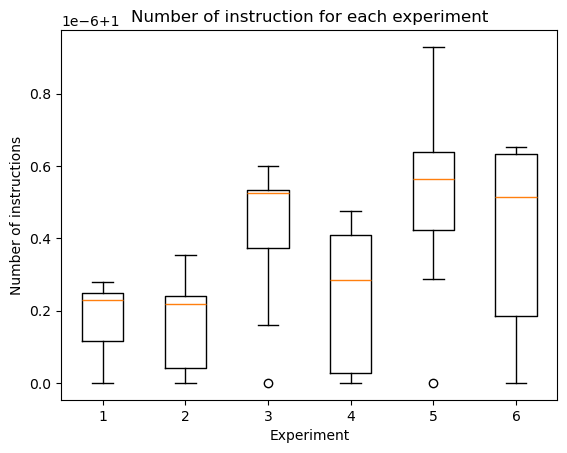

values should be close to 1
[array([1.        , 1.00000023, 1.00000006, 1.00000028, 1.00000026,
       1.00000023, 1.00000025, 1.00000024, 1.00000021, 1.00000008]), array([1.00000024, 1.00000007, 1.00000002, 1.        , 1.00000035,
       1.00000023, 1.00000025, 1.00000003, 1.00000023, 1.00000021]), array([1.00000054, 1.        , 1.00000052, 1.0000006 , 1.00000033,
       1.00000054, 1.00000016, 1.0000005 , 1.00000053, 1.00000053]), array([1.00000028, 1.00000045, 1.00000048, 1.00000046, 1.00000007,
       1.00000029, 1.00000029, 1.00000001, 1.00000001, 1.        ]), array([1.00000093, 1.00000056, 1.00000047, 1.0000004 , 1.00000064,
       1.00000063, 1.00000066, 1.00000057, 1.00000029, 1.        ]), array([1.00000063, 1.00000022, 1.00000065, 1.00000062, 1.00000064,
       1.00000041, 1.00000065, 1.00000015, 1.00000017, 1.        ])]
The mean is 1.0000003226779604
The max is 1.000000928967904


In [15]:
# Creating a boxplot for each experiment
# plt.boxplot([df['warmup_values'].iloc[i] for i in range(len(df))])
# plt.title('Number of instruction for each experiment')
# plt.ylabel('Number of instructions')
# plt.xlabel('Experiment')
# plt.show()

min_ratios = [df['warmup_values'].iloc[i] / df['warmup_values'].iloc[i].min() for i in range(len(df))]
plt.boxplot(min_ratios)
plt.title('Number of instruction for each experiment')
plt.ylabel('Number of instructions')
plt.xlabel('Experiment')
plt.show()

print("values should be close to 1")
print(min_ratios)
print(f"The mean is {np.mean(min_ratios)}")
print(f"The max is {np.max(min_ratios)}")

Each experiment should execute the same number of instructions, so we can combine all the warmup trials.

In [16]:
# NOTE: IGNORE COMBINED FOR DIFFERENT TEST INSTANCES
# combined_np_array = np.concatenate([df['warmup_values'].iloc[i] for i in range(len(df))])
# plt.boxplot(combined_np_array)
# plt.title('Number of instruction for each experiment')
# plt.ylabel('Number of instructions')
# plt.xlabel('Combined')
# plt.show()

In [17]:
# Let's also normalise by the minimum value
# percentage_diff_median = combined_np_array / combined_np_array.min()
# plt.boxplot(percentage_diff_median)
# plt.title('Minimum normalised number of instruction')
# plt.ylabel('Ratio of minimum value')
# plt.xlabel('Combined')
# plt.show()
# print("values should be close to 1 (however not for combined):")
# print(percentage_diff_median)

We notice that the variance is mostly consistance, however, at times the number of instructions exectued jump up very significantly. We will explore this further in the next section.

In [18]:
# combined_np_array

In [19]:
# def get_outliers():
#     # Get outliers
#     Q1 = np.quantile(combined_np_array, 0.25)
#     Q3 = np.quantile(combined_np_array, 0.75)
#     IQR = Q3 - Q1
#     outliers = combined_np_array[(combined_np_array < Q1 - 1.5 * IQR) | (combined_np_array > Q3 + 1.5 * IQR)]
#     return outliers

# outliers = get_outliers()

# print(f"There are {len(outliers)} outliers, so {len(outliers) * 100 / len(combined_np_array):.2f}% of the data is outliers")

# # Percentage difference from median
# average_outlier_magnitude = ((outliers / np.median(combined_np_array)) - 1) * 100
# if len(average_outlier_magnitude) > 0:
#     print(f"Average outlier magnitude: {np.mean(average_outlier_magnitude):.2f}%")

    

This essentially gives use evidence that parallisation will induce very significant noise. As context switching leads to an uptick in instruction count.

### Analyse experiment runs

#### Random Search

We simply compare operators between each other for random search.

In [20]:
unique_rl_algos = df['rl_algorithm'].unique()
unique_rl_algos

array(['ProbabilityMatching', 'EpsilonGreedy', 'UCB'], dtype=object)

In [21]:
def compare_rl_algos_as_box_plot(column_name, title, ylabel):
    box_mini_plot = []
    for rl_algo_name in unique_rl_algos:
        rl_algo = df[df['rl_algorithm'] == rl_algo_name]

        values = np.array(rl_algo[column_name])
        box_mini_plot.append(values)
    plt.boxplot(box_mini_plot, labels=unique_rl_algos)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

Efficiency

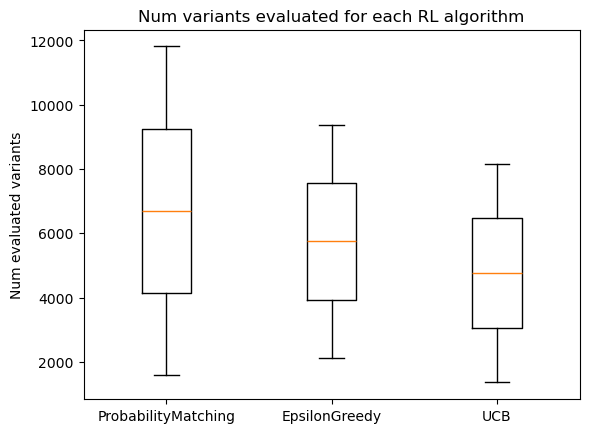

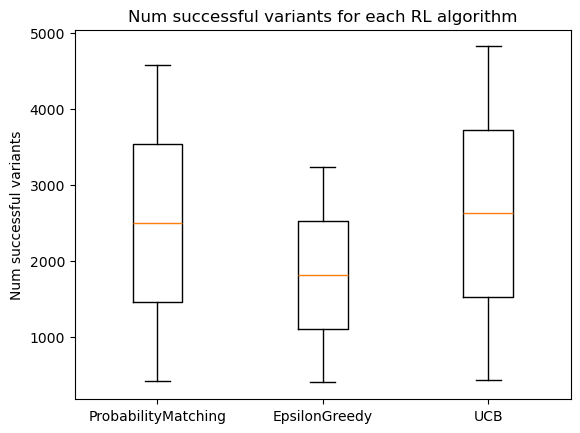

In [22]:
# compare_rl_algos_as_box_plot('successful_runs_percentage', 'Percentage of successful runs for each RL algorithm', 'Percentage of successful runs (%)')
compare_rl_algos_as_box_plot('num_unique_variants_evaluated', 'Num variants evaluated for each RL algorithm', 'Num evaluated variants')
compare_rl_algos_as_box_plot('num_unique_successful_variants_evaluated', 'Num successful variants for each RL algorithm', 'Num successful variants')

Efficacy

Of the successful runs, how effective is it at finding runtime improvements?

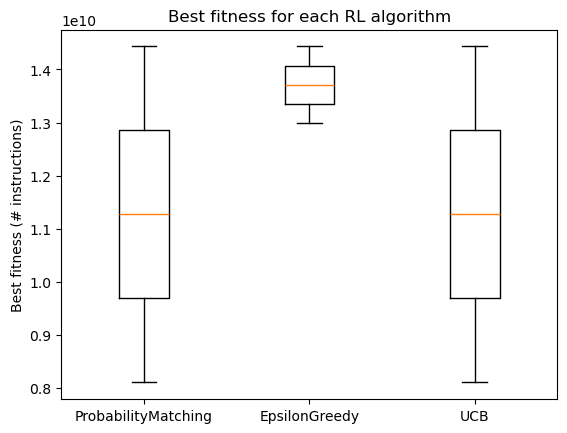

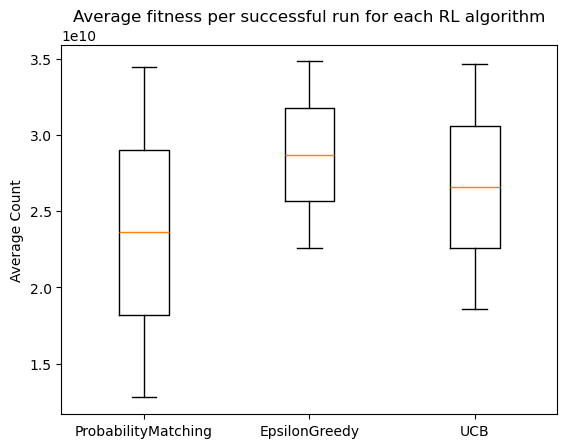

In [23]:
compare_rl_algos_as_box_plot('best_fitness', 'Best fitness for each RL algorithm', 'Best fitness (# instructions)')
# compare_rl_algos_as_box_plot('fitness_decrease_percentage', 'Best fitness decrease percentage for each RL algorithm', 'Fitness decrease percentage (%)')

df['run_times'] = df['pkl_obj'].apply(utils.get_run_times)

# Average runtime per successful run (shows if it learns to be more efficient as well)
df['average_instructions_count_per_successful_run'] = df['run_times'].apply(lambda x: np.mean(x))
compare_rl_algos_as_box_plot('average_instructions_count_per_successful_run', 'Average fitness per successful run for each RL algorithm', 'Average Count')

df['median_instructions_count_per_successful_run'] = df['run_times'].apply(lambda x: np.median(x))
# compare_rl_algos_as_box_plot('median_instructions_count_per_successful_run', 'Median fitness per successful run for each RL algorithm', 'Median Count')


RL Specific (combined efficiency and efficacy)

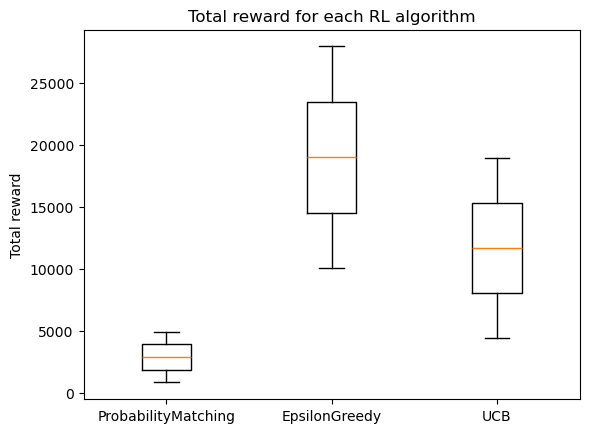

In [24]:
# Total reward (shows how much it could evaluate -- maybe incorporated runtime)
df['total_reward'] = df['rewards'].apply(lambda x: np.sum(x))
compare_rl_algos_as_box_plot('total_reward', 'Total reward for each RL algorithm', 'Total reward')

# Average reward per iteration (would probably favour UCB)
df['average_reward_per_iteration'] = df['rewards'].apply(lambda x: np.mean(x))
# compare_rl_algos_as_box_plot('average_reward_per_iteration', 'Average reward per iteration for each RL algorithm', 'Average reward per iteration')

# Median reward per iteration
df['median_reward_per_iteration'] = df['rewards'].apply(lambda x: np.median(x))
# compare_rl_algos_as_box_plot('median_reward_per_iteration', 'Median reward per iteration for each RL algorithm', 'Median reward per iteration')

Quality vs time

Results for trials of ProbabilityMatching


IndexError: single positional indexer is out-of-bounds

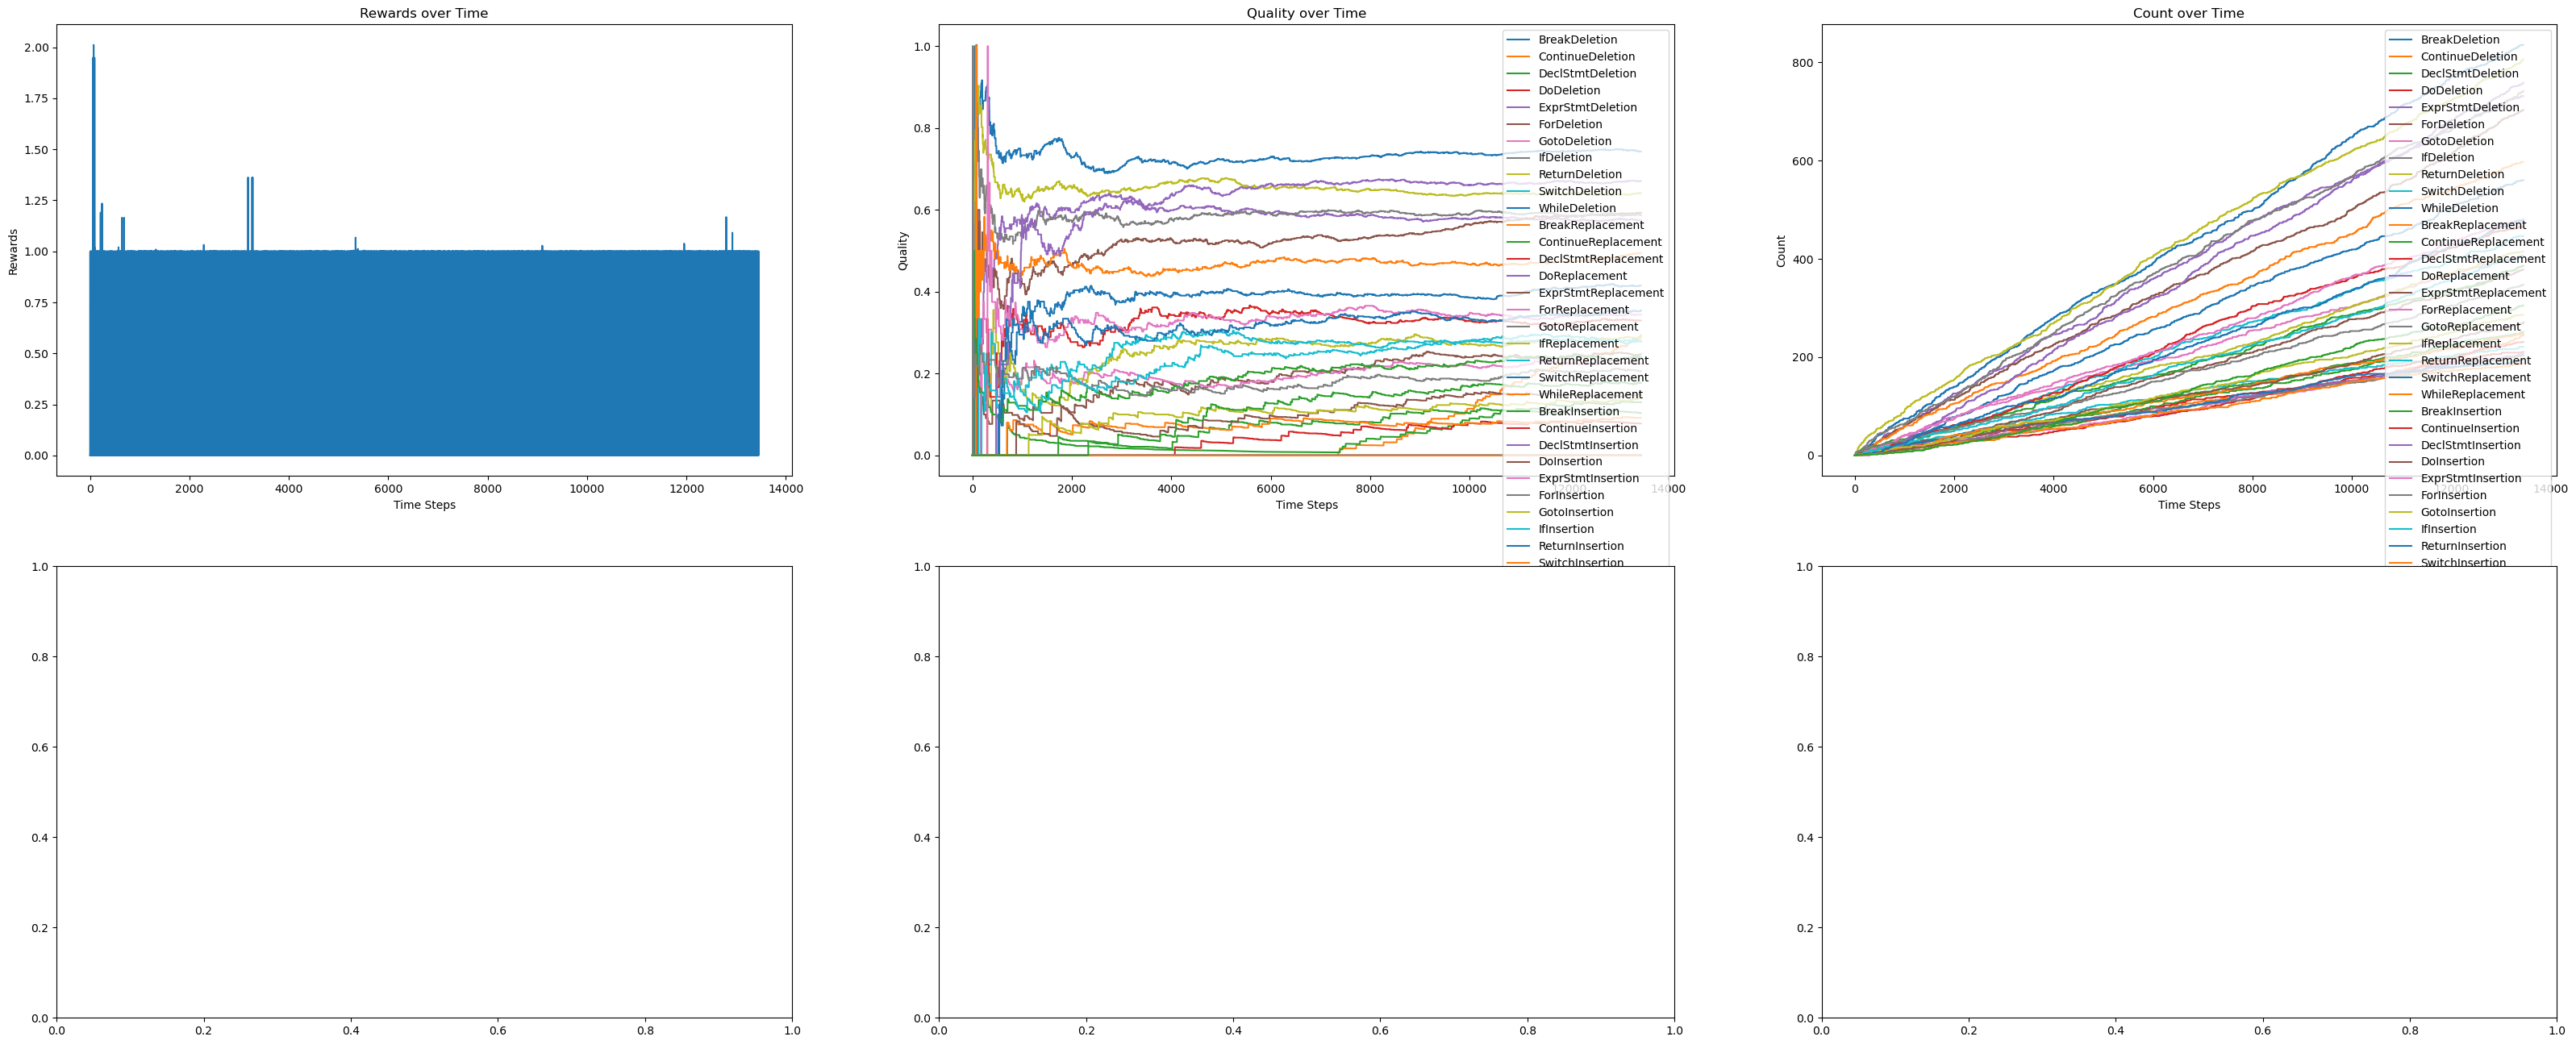

In [25]:
def plot_time_series(ax, series, series_name):
    time_steps = list(range(len(series)))
    ax.plot(time_steps, series)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(series_name)
    ax.set_title(f'{series_name} over Time')

def plot_rewards_vs_time(ax, op_selector):
    plot_time_series(ax, op_selector.reward_log, 'Rewards')

def plot_quality_vs_time(ax, op_selector):
    for operator in op_selector._operators:
        ax.plot([average_qualities[operator] for average_qualities in op_selector.average_qualities_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Quality')
    ax.set_title('Quality over Time')
    ax.legend()

def plot_count_vs_time(ax, op_selector):
    for operator in op_selector._operators:
        ax.plot([action_count[operator] for action_count in op_selector.action_count_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Count')
    ax.set_title('Count over Time')
    ax.legend()

for rl_algo_name in unique_rl_algos:

    print(f"Results for trials of {rl_algo_name}")
    df_rl = df[df['rl_algorithm'] == rl_algo_name]

    num_rows = len(df_rl)

    fig, axs = plt.subplots(num_rows, 3, figsize=(40, 8 * num_rows)) 
    if num_rows == 1: # Prevent single dimension error
        axs = np.array([axs])

    for trial_num in range(num_rows):
        op_selector = df_rl[df_rl['trial_number'] == str(trial_num)].iloc[0]['pkl_obj']['operator_selector']
        plot_rewards_vs_time(axs[trial_num, 0], op_selector)
        plot_quality_vs_time(axs[trial_num, 1], op_selector)
        plot_count_vs_time(axs[trial_num, 2], op_selector)

    plt.tight_layout()
    plt.show()


Specific to Policy Gradients

In [ ]:
def plot_preferences_vs_time(ax, op_selector):
    assert op_selector.__class__.__name__ == "PolicyGradient"
    for i, operator in enumerate(op_selector._operators):
        ax.plot([preferences[i] for preferences in op_selector._preferences_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Operator Preference')
    ax.set_title('Preference over Time')
    ax.legend()

def plot_policy_vs_time(ax, op_selector):
    assert op_selector.__class__.__name__ == "PolicyGradient"
    for i, operator in enumerate(op_selector._operators):
        ax.plot([policy[i] for policy in op_selector._policy_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Operator Probability')
    ax.set_title('Policy over Time')
    ax.legend()

def plot_average_rewards_vs_time(ax, op_selector):
    assert op_selector.__class__.__name__ == "PolicyGradient"
    plot_time_series(ax, op_selector._average_reward_log, 'Average Reward')

for rl_algo_name in unique_rl_algos:

    if rl_algo_name != "PolicyGradient":
        continue

    print(f"Results for trials of {rl_algo_name}")
    df_rl = df[df['rl_algorithm'] == rl_algo_name]

    num_rows = len(df_rl)

    fig, axs = plt.subplots(num_rows, 3, figsize=(40, 8 * num_rows)) 
    if num_rows == 1: # Prevent single dimension error
        axs = np.array([axs])

    for trial_num in range(num_rows):
        op_selector = df_rl[df_rl['trial_number'] == str(trial_num)].iloc[0]['pkl_obj']['operator_selector']
        plot_preferences_vs_time(axs[trial_num, 0], op_selector)
        plot_policy_vs_time(axs[trial_num, 1], op_selector)
        plot_average_rewards_vs_time(axs[trial_num, 2], op_selector)

    plt.tight_layout()
    plt.show()

Others vs time

In [ ]:
def plot_together_vs_time(col_name, ylabel, title):
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(df['rl_algorithm'].unique()))))

    for rl_algorithm in df['rl_algorithm'].unique():
        color = next(colors)
        df_algorithm = df[df['rl_algorithm'] == rl_algorithm]

        # Loop over the first n rows of df_algorithm
        n = len(df_algorithm)
        for i in range(n):
            if i == 0:
                # Plot the first line and set a label for the legend
                plt.plot(df_algorithm[col_name].iloc[i], color=color, label=rl_algorithm)
            else:
                # Plot the remaining lines without a label to avoid duplicate labels in the legend
                plt.plot(df_algorithm[col_name].iloc[i], color=color)

    plt.xlabel('Time Steps')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# plot_together_vs_time("cumulative_rewards", "Cumulative Reward", "Cumulative Reward over Time Step")

plot_together_vs_time("average_reward_vs_time", "Average Reward", "Average Reward per iteration over Time Step")

In [ ]:
unique_statuses = reduce(set.union, df['get_unique_statuses'])
unique_statuses

In [ ]:
# Generate the relevant columns
for unique_status in unique_statuses:
    df[f"{unique_status}_count_over_time"] = df['pkl_obj'].apply(lambda x: utils.get_status_cum_count(x, unique_status))

for unique_status in unique_statuses:
    df[f"{unique_status}_percentage_over_time"] = df[f"{unique_status}_count_over_time"].apply(lambda cum_array : cum_array * 100 / np.arange(1, len(cum_array) + 1))

for unique_status in ['SUCCESS']:
    # plot_together_vs_time(f"{unique_status}_count_over_time", f"{unique_status} Count", f"{unique_status} Count over Time")
    plot_together_vs_time(f"{unique_status}_percentage_over_time", f"{unique_status} Percentage (%)", f"{unique_status} Percentage over Time") 